In [1]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000
...,...,...,...,...,...
2020-09-13 14:55:57,130.0,0.0,1.054,0.0234,0.000000
2020-09-13 14:55:58,130.0,0.0,0.829,0.0258,0.000000
2020-09-13 14:55:59,129.0,0.0,0.616,-0.1686,0.000000


In [2]:
data.describe()

,heart-rate,cadence,speed,acceleration,slope
count,38254.000000,38254.000000,38254.000000,38254.000000,38254.000000
mean,141.385616,72.896876,8.203325,-0.002056,0.005646
std,16.562215,25.235907,2.603563,0.225916,0.108174
min,66.000000,0.000000,0.000000,-2.384600,-7.731092
25%,131.000000,73.000000,6.579000,-0.074400,0.000000
50%,142.000000,82.000000,8.297000,0.005800,0.000000
75%,153.000000,87.000000,9.874000,0.083800,0.010134
max,187.000000,107.000000,18.604000,1.311400,14.857143


In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.metrics import mean_absolute_error

import numpy as np


data_linear_model = pd.concat(
    {"speed^3": data["speed"] ** 3,
     "speed": data["speed"],
     "speed*sin(alpha)": data["speed"] * np.sin(np.arctan(data["slope"])),
     "speed*acceleration": data["speed"] * data["acceleration"].clip(lower=0)},
    axis=1
)
data_linear_model.mean()["speed*sin(alpha)"]

-0.002709709612566326

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.metrics import mean_absolute_error

In [5]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data_linear_model)


linear_model = RidgeCV()

cv = ShuffleSplit(n_splits=4, random_state=0)


results = cross_validate(linear_model, scaled_data, target, cv=cv, scoring='neg_mean_absolute_error', return_estimator=True, return_train_score=True)

train_mae = -results['train_score'].mean()
test_mae = -results['test_score'].mean()

print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train MAE: 72.47881101590481
Test MAE: 72.37222139895346


In [6]:
lineal_model_test = results["test_score"]
lineal_model_train = results["train_score"]

In [7]:
estimators = results['estimator']

for idx, estimator in enumerate(estimators):
    print(f"Coefficients for fold {idx+1}: {estimator.coef_}")


Coefficients for fold 1: [ 5.65147596 32.84268041 80.09906864 10.77877431]
Coefficients for fold 2: [ 5.70528515 32.88271827 81.04975864 11.32282827]
Coefficients for fold 3: [ 6.30066604 32.24258491 81.04154573 11.21096036]
Coefficients for fold 4: [ 6.18296397 32.43014062 80.68790995 11.28590648]


In [8]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [9]:
hgbdt = HistGradientBoostingRegressor(early_stopping=True, max_iter=1000)

cv = ShuffleSplit(n_splits=4, random_state=0)


results = cross_validate(hgbdt, data, target, cv=cv, scoring='neg_mean_absolute_error', return_estimator=True, return_train_score=True)

train_mae = -results['train_score'].mean()
test_mae = -results['test_score'].mean()

print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train MAE: 40.39948334809559
Test MAE: 43.92290126214569


In [10]:
hist_model_test = results["test_score"]
hist_model_train = results["train_score"]

In [11]:
-1*hist_model_test

array([44.30492871, 43.81483139, 43.84457377, 43.72727118])

In [12]:
-1*lineal_model_test

array([73.2300669 , 72.13117473, 72.89061748, 71.23702649])

In [13]:
-1*hist_model_train

array([39.42780121, 39.82461934, 41.14670785, 41.19880499])

In [14]:
-1*lineal_model_train

array([72.35634784, 72.51703963, 72.42974809, 72.6121085 ])

In [15]:
import numpy as np

unique_ride_dates = np.unique(cycling.index.date)
print(f"There are {len(unique_ride_dates)} bike rides")

There are 4 bike rides


In [16]:
unique_ride_dates

array([datetime.date(2020, 8, 18), datetime.date(2020, 8, 20),
       datetime.date(2020, 8, 26), datetime.date(2020, 9, 13)],
      dtype=object)

In [17]:
from sklearn.model_selection import LeaveOneGroupOut

groups, _ = pd.factorize(data_linear_model.index.date)
cv = LeaveOneGroupOut()

cv_results_linear_model = cross_validate(
    linear_model, data_linear_model, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)

errors_LOGO_lm = -cv_results_linear_model["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{errors_LOGO_lm.mean():.3f} +/- {errors_LOGO_lm.std():.3f} Watts")
errors_LOGO_lm = -cv_results_linear_model["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{errors_LOGO_lm.mean():.3f} +/- {errors_LOGO_lm.std():.3f} Watts")

errors_LOGO_hgbdt = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{errors_LOGO_hgbdt.mean():.3f} +/- {errors_LOGO_hgbdt.std():.3f} Watts")
errors_LOGO_hgbdt = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{errors_LOGO_hgbdt.mean():.3f} +/- {errors_LOGO_hgbdt.std():.3f} Watts")

Linear model - MAE on train sets:	 72.249 +/- 2.247 Watts
Linear model - MAE on test sets:	 73.014 +/- 5.778 Watts
Histogram GBDT - MAE on train sets:	 39.583 +/- 0.685 Watts
Histogram GBDT - MAE on test sets:	 49.299 +/- 2.705 Watts


In [18]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = data_linear_model.iloc[train_indices]
data_linear_model_test = data_linear_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

In [19]:
linear_model.fit(data_linear_model_train,target_train)

RidgeCV()

In [20]:
import matplotlib.pyplot as plt

target_predicted_linear_model = linear_model.predict(
    data_linear_model_test)

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_linear_model = mean_absolute_error(target_test,
                                       target_predicted_linear_model)

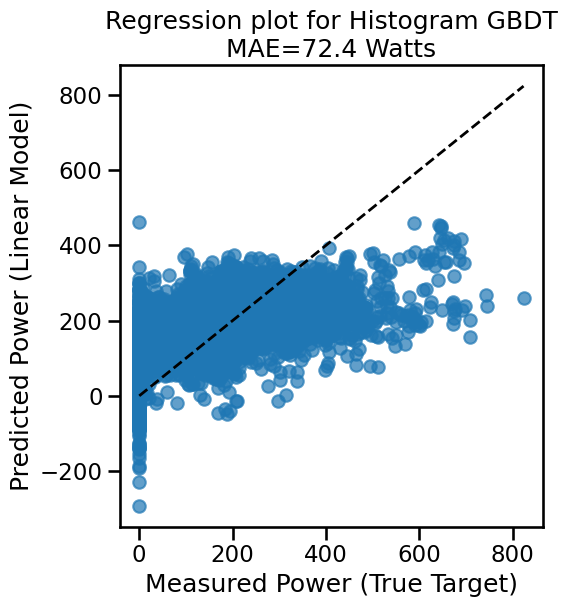

In [22]:
#Lineal
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(target_test, target_predicted_linear_model, alpha=0.7)
plt.xlabel('Measured Power (True Target)')
plt.ylabel('Predicted Power (Linear Model)')
plt.title('Linear Model Predictions')
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()],'k--', lw=2)
_ = plt.title(f"Regression plot for Histogram GBDT\n"
              f"MAE={mae_linear_model:.1f} Watts")

In [23]:
hgbdt.fit(data_train,target_train)

HistGradientBoostingRegressor(early_stopping=True, max_iter=1000)

In [24]:
target_predicted_hgbdt = hgbdt.predict(data_test)

In [25]:
mae_hgbdt = mean_absolute_error(target_test, target_predicted_hgbdt)

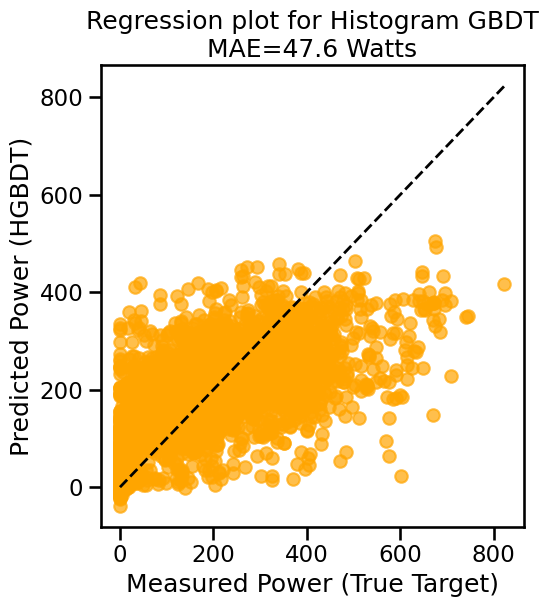

In [26]:
#Hist
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.scatter(target_test, target_predicted_hgbdt, alpha=0.7, color='orange')
plt.xlabel('Measured Power (True Target)')
plt.ylabel('Predicted Power (HGBDT)')
plt.title('HGBDT Predictions')
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2)
_ = plt.title(f"Regression plot for Histogram GBDT\n"
              f"MAE={mae_hgbdt:.1f} Watts")

In [27]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

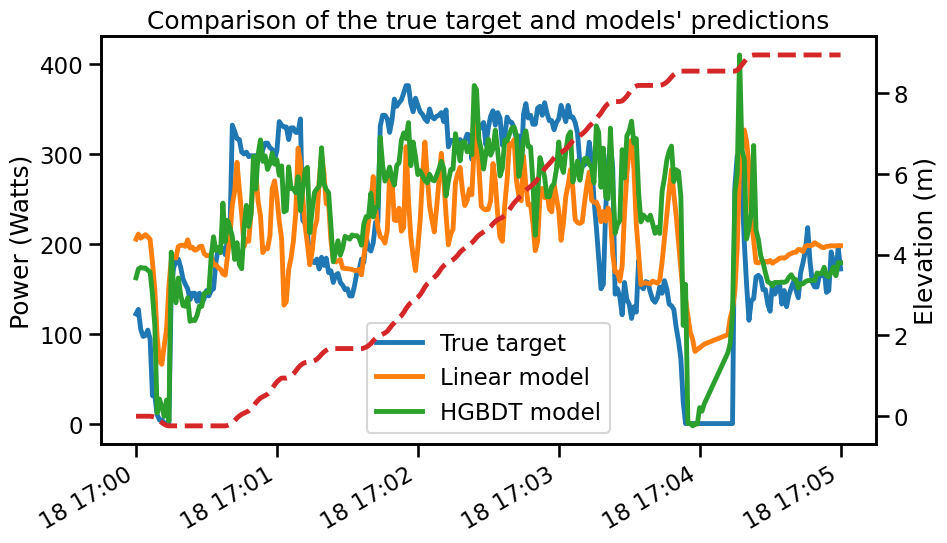

In [28]:
import matplotlib.pyplot as plt

time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

target_predicted_linear_model = linear_model.predict(
    data_test_linear_model_subset)
target_predicted_hgbdt = hgbdt.predict(data_test_subset)

ax = target_test_subset.plot(label="True target", figsize=(10, 6))
ax.plot(target_test_subset.index, target_predicted_linear_model,
        label="Linear model")
ax.plot(target_test_subset.index, target_predicted_hgbdt, label="HGBDT model")
ax.set_ylabel("Power (Watts)")
plt.legend()

ax_elevation = ax.twinx()
ax_elevation.plot(target_test_subset.index, data_test_subset["slope"].cumsum(),
                  color="tab:red", linestyle="--")
ax_elevation.set_ylabel("Elevation (m)")

_ = plt.title("Comparison of the true target and models' predictions")

In [29]:
mae_linear_model = mean_absolute_error(target_test_subset, target_predicted_linear_model)
mse_linear_model = mean_squared_error(target_test_subset, target_predicted_linear_model)
r2_linear_model = r2_score(target_test_subset, target_predicted_linear_model)

In [30]:
print("Linear Model Performance:")
print(f"MAE: {mae_linear_model}")
print(f"MSE: {mse_linear_model}")
print(f"R2: {r2_linear_model}")

Linear Model Performance:
MAE: 67.63591320080394
MSE: 6661.843579736452
R2: 0.38162444202141677


In [31]:
mae_hgbdt = mean_absolute_error(target_test_subset, target_predicted_hgbdt)
mse_hgbdt = mean_squared_error(target_test_subset, target_predicted_hgbdt)
r2_hgbdt = r2_score(target_test_subset, target_predicted_hgbdt)

In [32]:
print("HGBDT Model Performance:")
print(f"MAE: {mae_hgbdt}")
print(f"MSE: {mse_hgbdt}")
print(f"R2: {r2_hgbdt}")

HGBDT Model Performance:
MAE: 50.972900250585305
MSE: 4591.909258085047
R2: 0.5737629658113803
